In [4]:
import numpy as np
import pandas as pd
import os
import time
import keras
from keras import Input
from keras.layers import Dense, Reshape, LeakyReLU, Conv2D, Conv2DTranspose, Flatten, Dropout
from keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from tqdm import tqdm
from PIL import Image
from matplotlib import pyplot as plt
import imageio
import shutil

# Defining our dataset 

In [ ]:
PIC_DIR = f'img_align_celeba/'


IMAGES_COUNT = 10000

ORIG_WIDTH = 178
ORIG_HEIGHT = 208
diff = (ORIG_HEIGHT - ORIG_WIDTH) // 2

WIDTH = 128
HEIGHT = 128

crop_rect = (0, diff, ORIG_WIDTH, ORIG_HEIGHT - diff)

images = []
for pic_file in tqdm(os.listdir(PIC_DIR)[:IMAGES_COUNT]):
    pic = Image.open(PIC_DIR + pic_file).crop(crop_rect)
    pic.thumbnail((WIDTH, HEIGHT), Image.LANCZOS)
    images.append(np.uint8(pic))


 51%|███████████████████████████████████████▌                                     | 2138/4157 [00:02<00:02, 790.64it/s]

In [6]:
images = np.array(images) / 255
print(images.shape)

(4157, 128, 128, 3)


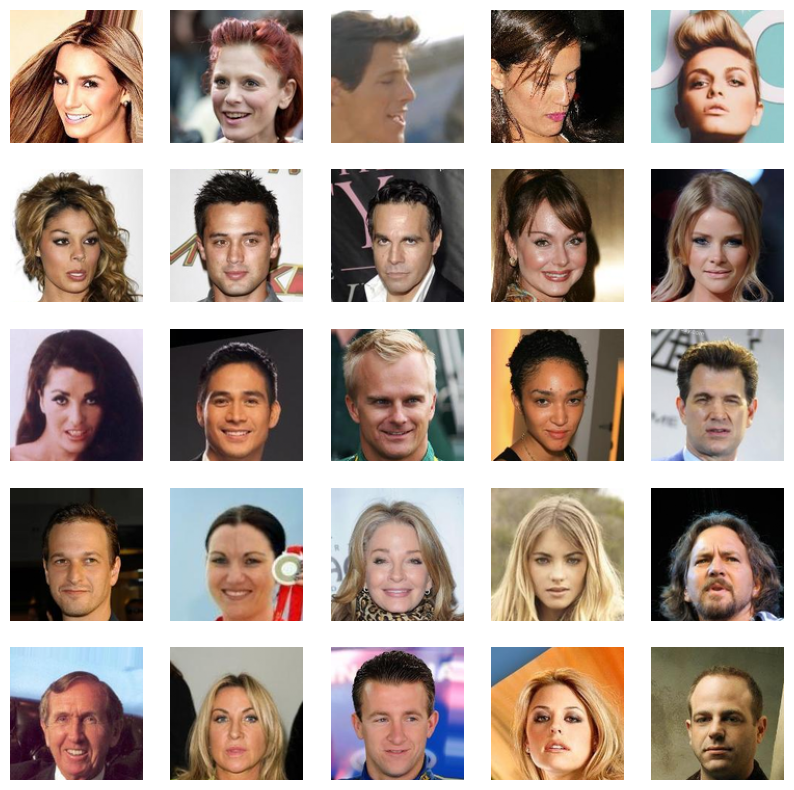

In [3]:
plt.figure(1, figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(images[i])
    plt.axis('off')
plt.show()

# Creating the model

In [7]:
LATENT_DIM = 32
CHANNELS = 3

def create_generator():
    gen_input = Input(shape=(LATENT_DIM, ))

    x = Dense(128 * 16 * 16)(gen_input)
    x = LeakyReLU()(x)
    x = Reshape((16, 16, 128))(x)

    x = Conv2D(256, 5, padding='same')(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    x = LeakyReLU()(x)

    x = Conv2D(512, 5, padding='same')(x)
    x = LeakyReLU()(x)
    x = Conv2D(512, 5, padding='same')(x)
    x = LeakyReLU()(x)
    x = Conv2D(CHANNELS, 7, activation='tanh', padding='same')(x)

    generator = Model(gen_input, x)
    return generator

def create_discriminator():
    disc_input = Input(shape=(HEIGHT, WIDTH, CHANNELS))

    x = Conv2D(256, 3)(disc_input)
    x = LeakyReLU()(x)

    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)

    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)

    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)

    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)

    x = Flatten()(x)
    x = Dropout(0.4)(x)

    x = Dense(1, activation='sigmoid')(x)
    discriminator = Model(disc_input, x)

    optimizer = RMSprop(
        lr=.0001,
        clipvalue=1.0,
        decay=1e-8
    )

    discriminator.compile(
        optimizer=optimizer,
        loss='binary_crossentropy'
    )

    return discriminator

generator = create_generator()
discriminator = create_discriminator()
discriminator.trainable = True


C:\Users\Alejandro\anaconda3-1\lib\site-packages\keras\optimizers\optimizer_v2\rmsprop.py:140: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [7]:
 gan_input = Input(shape=(LATENT_DIM, ))
gan_output = discriminator(generator(gan_input))
gan = Model(gan_input, gan_output)

optimizer = RMSprop(lr=.0001, clipvalue=1.0, decay=1e-8)
gan.compile(optimizer=optimizer, loss='binary_crossentropy')



# Training model

In [8]:
def train(iters):
    start = 0
    d_losses = []
    a_losses = []
    images_saved = 0
    for step in range(iters):
        start_time = time.time()
        
        latent_vectors = np.random.normal(size=(batch_size, LATENT_DIM))
        generated = generator.predict(latent_vectors)

        real = images[start:start + batch_size]
        combined_images = np.concatenate([generated, real])

        labels = np.concatenate([np.ones((batch_size, 1)), np.zeros((batch_size, 1))])
        labels += .05 * np.random.random(labels.shape)

        d_loss = discriminator.train_on_batch(combined_images, labels)
        d_losses.append(d_loss)

        latent_vectors = np.random.normal(size=(batch_size, LATENT_DIM))
        misleading_targets = np.zeros((batch_size, 1))

        a_loss = gan.train_on_batch(latent_vectors, misleading_targets)
        a_losses.append(a_loss)

        start += batch_size
        if start > images.shape[0] - batch_size:
            start = 0

        if step % 100 == 99:
            gan.save_weights(f'models/gan_{int((step+1)/100)}.h5')

            print('%d/%d: d_loss: %.4f,  a_loss: %.4f.  (%.1f sec)' % (step + 1, iters, d_loss, a_loss, time.time() - start_time))

            control_image = np.zeros((WIDTH * CONTROL_SIZE_SQRT, HEIGHT * CONTROL_SIZE_SQRT, CHANNELS))
            control_generated = generator.predict(control_vectors)
            for i in range(CONTROL_SIZE_SQRT ** 2):
                x_off = i % CONTROL_SIZE_SQRT
                y_off = i // CONTROL_SIZE_SQRT
                control_image[x_off * WIDTH:(x_off + 1) * WIDTH, y_off * HEIGHT:(y_off + 1) * HEIGHT, :] = control_generated[i, :, :, :]
            im = Image.fromarray(np.uint8(control_image * 255))
            im.save(FILE_PATH % (RES_DIR, images_saved))
            images_saved += 1


50/15000: d_loss: 0.6330,  a_loss: 1.1520.  (1.2 sec)
100/15000: d_loss: 0.7476,  a_loss: 1.0939.  (1.3 sec)
150/15000: d_loss: 0.6747,  a_loss: 0.8692.  (1.6 sec)
200/15000: d_loss: 0.6384,  a_loss: 0.9464.  (1.2 sec)
250/15000: d_loss: 0.6659,  a_loss: 0.7421.  (1.2 sec)
300/15000: d_loss: 1.2611,  a_loss: 1.9735.  (1.2 sec)
350/15000: d_loss: 0.6933,  a_loss: 0.8631.  (1.2 sec)
400/15000: d_loss: 0.6519,  a_loss: 0.8119.  (1.2 sec)
450/15000: d_loss: 0.7211,  a_loss: 0.8206.  (1.3 sec)
500/15000: d_loss: 0.6423,  a_loss: 0.8333.  (1.3 sec)
550/15000: d_loss: 0.6262,  a_loss: 0.8383.  (1.2 sec)
600/15000: d_loss: 0.6428,  a_loss: 0.8787.  (1.2 sec)
650/15000: d_loss: 0.6390,  a_loss: 0.9350.  (1.4 sec)
700/15000: d_loss: 0.6609,  a_loss: 0.8188.  (1.2 sec)
750/15000: d_loss: 0.7277,  a_loss: 0.8124.  (1.2 sec)
800/15000: d_loss: 0.6909,  a_loss: 0.7948.  (1.2 sec)
850/15000: d_loss: 0.6892,  a_loss: 0.8944.  (1.2 sec)
900/15000: d_loss: 0.6956,  a_loss: 0.8860.  (1.2 sec)
950/15000: 

7400/15000: d_loss: 0.5621,  a_loss: 1.2310.  (1.2 sec)
7450/15000: d_loss: 0.6249,  a_loss: 1.0636.  (1.2 sec)
7500/15000: d_loss: 0.6252,  a_loss: 0.9310.  (1.2 sec)
7550/15000: d_loss: 0.6047,  a_loss: 1.0349.  (1.2 sec)
7600/15000: d_loss: 0.6182,  a_loss: 1.3622.  (1.2 sec)
7650/15000: d_loss: 0.6529,  a_loss: 0.9994.  (1.2 sec)
7700/15000: d_loss: 0.6385,  a_loss: 1.0686.  (1.2 sec)
7750/15000: d_loss: 0.5843,  a_loss: 1.1975.  (1.2 sec)
7800/15000: d_loss: 0.6055,  a_loss: 1.1913.  (1.2 sec)
7850/15000: d_loss: 0.5622,  a_loss: 1.1522.  (1.2 sec)
7900/15000: d_loss: 0.5856,  a_loss: 1.0353.  (1.2 sec)
7950/15000: d_loss: 0.5808,  a_loss: 0.8901.  (1.2 sec)
8000/15000: d_loss: 0.5726,  a_loss: 1.1533.  (1.2 sec)
8050/15000: d_loss: 0.7913,  a_loss: 0.7944.  (1.2 sec)
8100/15000: d_loss: 0.5478,  a_loss: 1.0372.  (1.2 sec)
8150/15000: d_loss: 0.6416,  a_loss: 1.2938.  (1.2 sec)
8200/15000: d_loss: 0.6030,  a_loss: 1.1660.  (1.2 sec)
8250/15000: d_loss: 0.7522,  a_loss: 1.2437.  (1

14650/15000: d_loss: 0.6736,  a_loss: 1.5452.  (1.2 sec)
14700/15000: d_loss: 0.3649,  a_loss: 1.7736.  (1.2 sec)
14750/15000: d_loss: 0.4717,  a_loss: 1.7690.  (1.2 sec)
14800/15000: d_loss: 0.4017,  a_loss: 1.5423.  (1.2 sec)
14850/15000: d_loss: 0.3587,  a_loss: 1.2443.  (1.2 sec)
14900/15000: d_loss: 0.4669,  a_loss: 1.5687.  (1.2 sec)
14950/15000: d_loss: 0.6991,  a_loss: 1.5637.  (1.2 sec)
15000/15000: d_loss: 0.5120,  a_loss: 2.3244.  (1.2 sec)


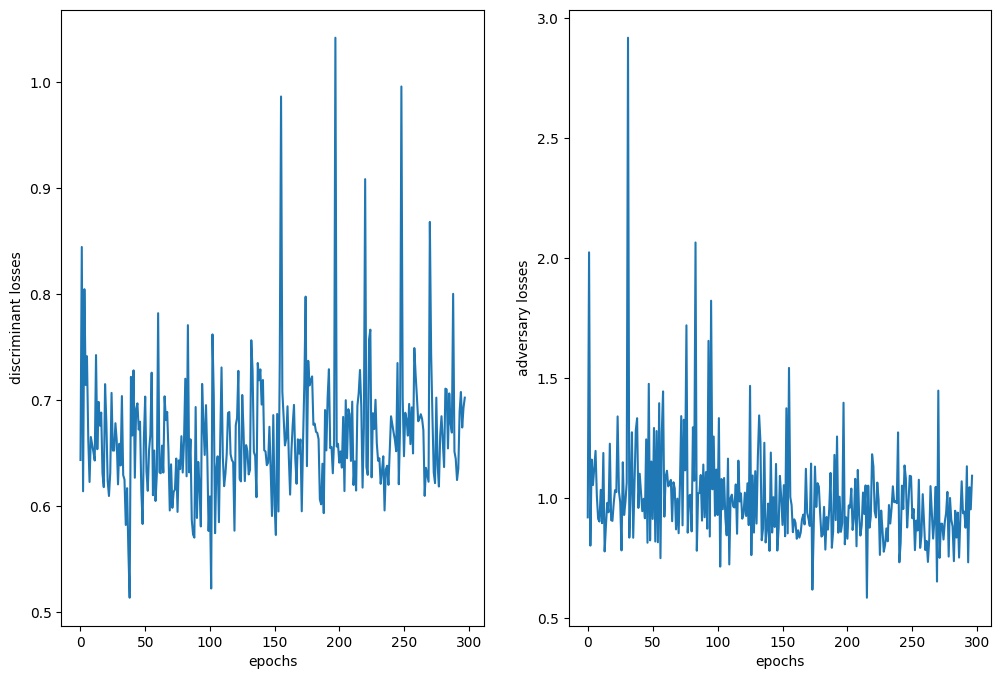

In [17]:
epochs = 300
iters = 50*epochs
batch_size = 16

RES_DIR = 'res2'
FILE_PATH = '%s/generated_%d.png'
if not os.path.isdir(RES_DIR):
    os.mkdir(RES_DIR)

CONTROL_SIZE_SQRT = 6
control_vectors = np.random.normal(size=(CONTROL_SIZE_SQRT**2, LATENT_DIM)) / 2

train(iters)

plt.figure(1, figsize=(12, 8))
plt.subplot(121)
plt.plot(d_losses)
plt.xlabel('epochs')
plt.ylabel('discriminant losses')
plt.subplot(122)
plt.plot(a_losses)
plt.xlabel('epochs')
plt.ylabel('adversary losses')
plt.show()

In [19]:
images_to_gif = []
for filename in os.listdir(RES_DIR):
    images_to_gif.append(imageio.imread(RES_DIR + '/' + filename))
imageio.mimsave('visual.gif', images_to_gif)
shutil.rmtree(RES_DIR)


C:\Users\Alejandro\AppData\Local\Temp\ipykernel_6908\2868511877.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images_to_gif.append(imageio.imread(RES_DIR + '/' + filename))


# Loading model and generating images

In [22]:
LATENT_DIM = 32
CHANNELS = 3

generator = create_generator()
discriminator = create_discriminator()
discriminator.trainable = False

gan_input = Input(shape=(LATENT_DIM, ))
gan_output = discriminator(generator(gan_input))
gan = Model(gan_input, gan_output)

optimizer = RMSprop(lr=.0001, clipvalue=1.0, decay=1e-8)
gan.load_weights('models/gan_1200e.h5')
gan.compile(optimizer=optimizer, loss='binary_crossentropy')

1/1 [==============================] - 1s 954ms/step


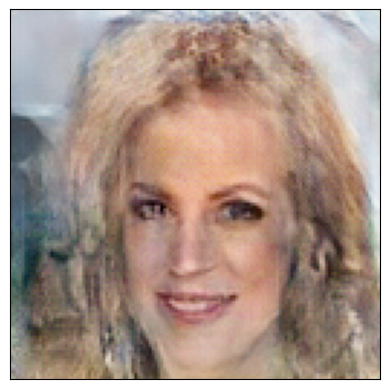

In [26]:
latent_vectors = np.random.normal(size=(1, LATENT_DIM))
generated = generator.predict(latent_vectors)
plt.imshow(np.clip((generated[0]), 0, 1))    
plt.xticks([])
plt.yticks([])
plt.grid()

# Further training of the model

In [14]:
epochs = 100

iters = 100 * epochs
batch_size = 16

RES_DIR = 'res2'
FILE_PATH = '%s/generated_%d.png'
if not os.path.isdir(RES_DIR):
    os.mkdir(RES_DIR)

CONTROL_SIZE_SQRT = 6
control_vectors = np.random.normal(size=(CONTROL_SIZE_SQRT**2, LATENT_DIM)) / 2

train(iters)
gan.save_weights(f'models/gan_latest.h5')

plt.figure(1, figsize=(12, 8))
plt.subplot(121)
plt.plot(d_losses)
plt.xlabel('epochs')
plt.ylabel('discriminant losses')
plt.subplot(122)
plt.plot(a_losses)
plt.xlabel('epochs')
plt.ylabel('adversary losses')
plt.show()

1/1 [==============================] - 13s 13s/step


KeyboardInterrupt: 